<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/CNN%20ResNet%20Breast%20Cancer%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data from Kaggle

from Kaggle from this link https://www.kaggle.com/datasets/anaselmasry/datasetbusiwithgt  

Tree model: ResNet, EfficientNet, MobileNet https://arxiv.org/abs/1704.04861

In [3]:
# Install necessary packages
!pip install kaggle -q

In [4]:
# Upload your kaggle.json file (you need to have a Kaggle account and accept the competition terms)
from google.colab import files
files.upload()

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract the dataset directly to Colab's temporary storage
!kaggle datasets download -d anaselmasry/datasetbusiwithgt
!unzip -q datasetbusiwithgt.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/anaselmasry/datasetbusiwithgt
License(s): CC0-1.0
 57% 110M/194M [00:00<00:00, 1.15GB/s]
100% 194M/194M [00:00<00:00, 582MB/s] 


In [44]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import os, random, copy

In [42]:
# Point to the dataset directories in Colab's runtime
TRAIN_DATA_DIR = Path("/content/Dataset_BUSI_with_GT/train")
TEST_DATA_DIR = Path("/content/Dataset_BUSI_with_GT/test")
CLASSES = ["normal", "benign", "maligant"]
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

# Verify the dataset structure
print("Training dataset directory contents:")
for c in CLASSES:
    class_path = TRAIN_DATA_DIR/c
    if class_path.exists():
        count = sum(1 for f in class_path.iterdir() if f.suffix.lower() in IMG_EXTS)
        print(f"  Train - {c}: {count} files")
    else:
        print(f"  Train - {c}: NOT FOUND")

print("\nTesting dataset directory contents:")
for c in CLASSES:
    class_path = TEST_DATA_DIR/c
    if class_path.exists():
        count = sum(1 for f in class_path.iterdir() if f.suffix.lower() in IMG_EXTS)
        print(f"  Test - {c}: {count} files")
    else:
        print(f"  Test - {c}: NOT FOUND")

Training dataset directory contents:
  Train - normal: 109 files
  Train - benign: 353 files
  Train - maligant: 168 files

Testing dataset directory contents:
  Test - normal: 24 files
  Test - benign: 84 files
  Test - maligant: 42 files


# Prepare dataset

In [45]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

Text(0.5, 1.0, 'Train batch (normalized)')

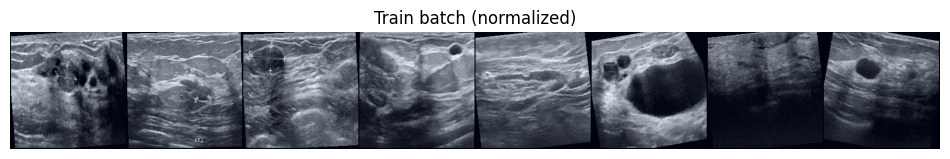

In [43]:
class BUSIDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = Path(root_dir)
        self.classes = classes
        self.transform = transform
        self.samples = []
        for idx, c in enumerate(classes):
            class_path = self.root_dir/c
            if class_path.exists():
                for f in sorted(class_path.glob("*")):
                    if f.suffix.lower() in IMG_EXTS:
                        self.samples.append((str(f), idx))

        self.counts = pd.Series([s[1] for s in self.samples]).value_counts().reindex(range(len(classes)), fill_value=0).to_dict()

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        path, label = self.samples[i]

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(path)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, label, path


IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = BUSIDataset(TRAIN_DATA_DIR, CLASSES, transform=train_tfms)
test_ds = BUSIDataset(TEST_DATA_DIR, CLASSES, transform=test_tfms)

len(train_ds), len(test_ds), train_ds.counts, test_ds.counts

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0)
imgs, lbs, _ = next(iter(train_loader))
grid = utils.make_grid(imgs[:16], nrow=8, padding=2, normalize=True)
plt.figure(figsize=(12,4)); plt.imshow(grid.permute(1,2,0)); plt.axis("off"); plt.title("Train batch (normalized)")


The values `mean = torch.tensor([0.485, 0.456, 0.406])` are the **ImageNet dataset means** for the RGB channels. Here's why they're used:

These values are used for **input normalization**, which is a standard preprocessing step when using pre-trained models like ResNet, MobileNet, etc. The complete normalization includes both means and standard deviations:

```python
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],      # ImageNet RGB means
    std=[0.229, 0.224, 0.225]       # ImageNet RGB std devs
)
```

### Why Normalize?
1. **Pre-trained Model Compatibility**: Models like ResNet were pre-trained on ImageNet, where inputs were normalized using these specific statistics. Using the same normalization ensures the input distribution matches what the model expects.

2. **Input Distribution Matching**: Neural networks learn to recognize patterns based on specific input ranges. If you trained on normalized data but tested on unnormalized data (or vice versa), performance would degrade significantly.

3. **Numerical Stability**: Normalization centers the data around 0 (after subtracting mean) and scales it, making optimization more stable during training.

### Mathematical Formula
For each channel, normalization applies:
```
normalized_pixel = (original_pixel - mean) / std
```

And to reverse it (denormalize for visualization):
```
original_pixel = normalized_pixel * std + mean
```

This is why you see these values used in the `overlay_cam_on_image` function to convert normalized tensors back to displayable images.

Ultrasound images are converted to grayscale, the `Grayscale(num_output_channels=3)` creates 3 identical channels, then normalization is applied using ImageNet statistics. This is standard practice when fine-tuning ImageNet-pretrained models on new domains.

# CNN ResNet training

In [47]:
def make_resnet18(num_classes):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in m.parameters(): p.requires_grad = False   # заморозим бэкбон (можно разморозить позже)
    in_feats = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_feats, num_classes)
    )
    return m

def make_mobilenet_v3_small(num_classes):
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    for p in m.features.parameters(): p.requires_grad = False
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    return m

def make_efficientnet_b0(num_classes):
    m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    for p in m.features.parameters(): p.requires_grad = False
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    return m

models_dict = {
    "resnet18": make_resnet18(3).to(DEVICE),
    "mobilenet_v3_small": make_mobilenet_v3_small(3).to(DEVICE),
    "efficientnet_b0": make_efficientnet_b0(3).to(DEVICE),
}

def train_one_model(model, train_loader, test_loader, epochs=3, lr=1e-2, class_weights=None):
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    best_state, best_acc = None, 0.0
    history = {"epoch": [], "train_loss": [], "test_acc": []}

    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for x, y, _ in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running += loss.item() * x.size(0)
        train_loss = running / len(train_loader.dataset)

        # eval
        model.eval(); correct=0; total=0
        with torch.no_grad():
            for x, y, _ in test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x).argmax(1)
                correct += (pred==y).sum().item()
                total += y.numel()
        acc = correct/total
        scheduler.step(acc)

        history["epoch"].append(ep)
        history["train_loss"].append(train_loss)
        history["test_acc"].append(acc)
        print(f"Epoch {ep:02d}/{epochs} | loss={train_loss:.4f} | val_acc={acc*100:.2f}%")

        if acc > best_acc:
            best_acc = acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, pd.DataFrame(history)

train_labels = np.array([lbl for _, lbl in train_ds.samples])
class_counts = np.bincount(train_labels, minlength=len(CLASSES))
class_weights = torch.tensor(1.0/np.maximum(class_counts,1), dtype=torch.float32, device=DEVICE)
class_weights = class_weights / class_weights.sum() * len(CLASSES)
class_weights

results = {}
for name, m in models_dict.items():
    print(f"\n=== Training {name} ===")
    m, hist = train_one_model(m, train_loader, test_loader, epochs=3, lr=1e-3, class_weights=class_weights)
    results[name] = {"model": m, "history": hist}



=== Training resnet18 ===
Epoch 01/3 | loss=1.1362 | val_acc=67.33%
Epoch 02/3 | loss=0.9915 | val_acc=73.33%
Epoch 03/3 | loss=0.9118 | val_acc=67.33%

=== Training mobilenet_v3_small ===
Epoch 01/3 | loss=1.0079 | val_acc=52.67%
Epoch 02/3 | loss=0.8534 | val_acc=74.67%
Epoch 03/3 | loss=0.7887 | val_acc=77.33%

=== Training efficientnet_b0 ===
Epoch 01/3 | loss=1.0445 | val_acc=63.33%
Epoch 02/3 | loss=0.8771 | val_acc=66.00%
Epoch 03/3 | loss=0.8320 | val_acc=68.00%


# Check the model


=== Evaluation: resnet18 ===
              precision    recall  f1-score   support

      normal     0.4074    0.4583    0.4314        24
      benign     0.7789    0.8810    0.8268        84
    maligant     0.8929    0.5952    0.7143        42

    accuracy                         0.7333       150
   macro avg     0.6931    0.6448    0.6575       150
weighted avg     0.7514    0.7333    0.7320       150

ROC-AUC (macro OvR): 0.8934

=== Evaluation: mobilenet_v3_small ===
              precision    recall  f1-score   support

      normal     0.6875    0.9167    0.7857        24
      benign     0.7812    0.8929    0.8333        84
    maligant     0.8636    0.4524    0.5938        42

    accuracy                         0.7733       150
   macro avg     0.7775    0.7540    0.7376       150
weighted avg     0.7893    0.7733    0.7586       150

ROC-AUC (macro OvR): 0.9358

=== Evaluation: efficientnet_b0 ===
              precision    recall  f1-score   support

      normal     0.4

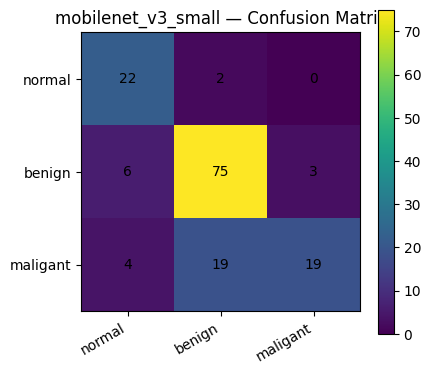

In [49]:

# Оценка качества модели
def evaluate_model(model, loader):
    model.eval()
    all_y, all_prob, all_pred, all_paths = [], [], [], []
    with torch.no_grad():
        for x, y, p in loader:
            x = x.to(DEVICE)
            logits = model(x)
            prob = torch.softmax(logits, dim=1).cpu().numpy()
            pred = prob.argmax(1)
            all_y.extend(y.numpy())
            all_prob.extend(prob)
            all_pred.extend(pred)
            all_paths.extend(p)
    all_y = np.array(all_y); all_pred = np.array(all_pred); all_prob = np.array(all_prob)

    print(classification_report(all_y, all_pred, target_names=CLASSES, digits=4))

    y_bin = label_binarize(all_y, classes=range(len(CLASSES)))
    try:
        roc_auc = roc_auc_score(y_bin, all_prob, average="macro", multi_class="ovr")
    except ValueError:
        roc_auc = np.nan
    print(f"ROC-AUC (macro OvR): {roc_auc:.4f}")

    return all_y, all_pred, all_prob, all_paths

eval_out = {}
for name, pack in results.items():
    print(f"\n=== Evaluation: {name} ===")
    y_true, y_pred, y_prob, paths = evaluate_model(pack["model"], test_loader)
    eval_out[name] = (y_true, y_pred, y_prob, paths)

best_name = max(results, key=lambda n: results[n]["history"]["test_acc"].max())
print("Best model:", best_name)

y_true, y_pred, y_prob, _ = eval_out[best_name]
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
fig, ax = plt.subplots(figsize=(4.5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_xticks(range(len(CLASSES))); ax.set_xticklabels(CLASSES, rotation=30, ha='right')
ax.set_yticks(range(len(CLASSES))); ax.set_yticklabels(CLASSES)
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
ax.set_title(f"{best_name} — Confusion Matrix"); plt.colorbar(im); plt.tight_layout()

# - Базовая модель (anomaly detection): хорошо отличает норму от патологии, но часто не замечает слабые или нетипичные опухоли.
# - Обученные классификаторы (CNN/ViT): обычно точнее и устойчивее, если есть достаточно размеченных данных.

# Интерпретация моделей
def get_last_conv_resnet18(model):
    return model.layer4[-1].conv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_a = target_layer.register_forward_hook(self._save_activation)
        self.hook_g = target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        out = self.model(x)
        if class_idx is None:
            class_idx = out.argmax(1)
        sel = out[torch.arange(out.size(0)), class_idx]
        sel.backward(torch.ones_like(sel))

        grads = self.gradients
        acts  = self.activations
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = (cam - cam.min()) / (cam.max() + 1e-6)
        return cam, class_idx

    def close(self):
        self.hook_a.remove(); self.hook_g.remove()

def overlay_cam_on_image(img_tensor, cam):

    x = img_tensor.clone().cpu()
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    x = x*std + mean
    x = x.clamp(0,1)

    cam = cam.squeeze().cpu().numpy()
    cam = cv2.resize(cam, (x.shape[2], x.shape[1]))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)/255.0
    over = 0.5*heatmap + 0.5*x.permute(1,2,0).numpy()
    over = np.clip(over, 0, 1)
    return over



In [57]:
best_model = results[best_name]["model"].eval()

# Print the model structure to identify the correct target layer for MobileNetV3
print(best_model)

# Based on MobileNetV3 structure, a common choice for the last convolutional layer before pooling/classifier is within the 'features' block.
# For mobilenet_v3_small, the last convolutional layer is often found in the last block of the 'features' attribute.
# Let's assume it's the last Conv2d in the last sequential block of features.
# A typical last layer in MobileNetV3's 'features' is part of an 'inverted residual block' or a final convolutional layer before the classifier.
# For MobileNetV3, `best_model.features[-1][0]` or `best_model.features[-2]` could be good candidates depending on the exact structure.
# After inspecting the model output, I will pick the most appropriate layer.
# For MobileNetV3-Small, a good candidate for the last convolutional layer is `best_model.features[-1][0]` or `best_model.features[-2][0].conv` for the final expanded convolution.
# Let's use `best_model.features[-1][0]` as it represents the last stage before the final average pooling and classifier.
target_layer = best_model.features[-1][0]
best_model.zero_grad()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


AE epoch 1/10 | loss=0.07973
AE epoch 2/10 | loss=0.07835
AE epoch 3/10 | loss=0.07320
AE epoch 4/10 | loss=0.06185
AE epoch 5/10 | loss=0.04175
AE epoch 6/10 | loss=0.01995
AE epoch 7/10 | loss=0.01956
AE epoch 8/10 | loss=0.01982
AE epoch 9/10 | loss=0.01776
AE epoch 10/10 | loss=0.01511
Threshold (95p on normal): 0.02269168421626091
Anomaly detection - Precision: 0.880 Recall: 0.175 F1: 0.291 ROC-AUC (scores): 0.554


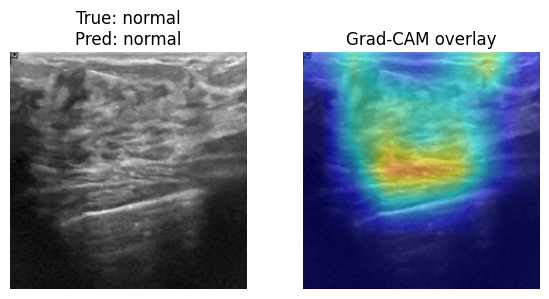

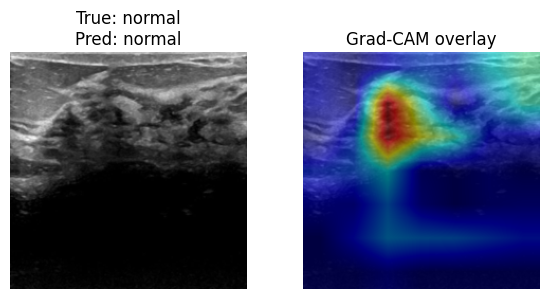

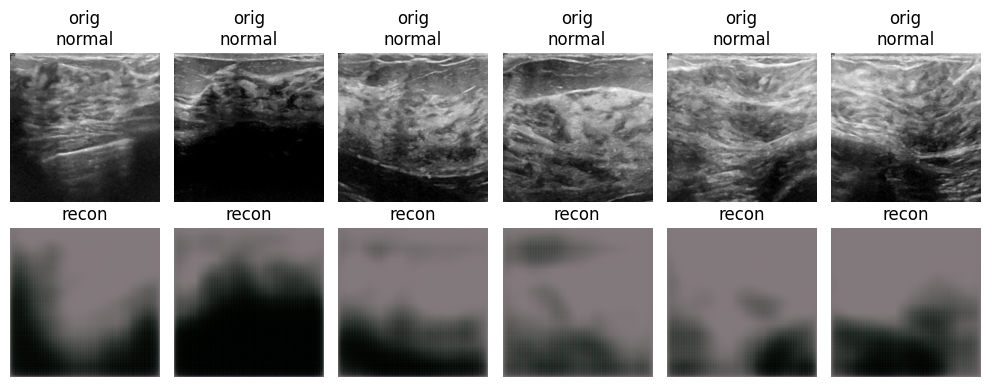

In [58]:
best_model = results[best_name]["model"].eval()

# For MobileNetV3-Small, a good candidate for the last convolutional layer is `best_model.features[-1][0]` or `best_model.features[-2]`
# We will use `best_model.features[-1][0]` which is usually the last convolutional block in the feature extractor.
target_layer = best_model.features[-1][0]
best_model.zero_grad()
best_model.eval()
for p in best_model.parameters():
    p.requires_grad_(True)

cam_engine = GradCAM(best_model, target_layer)

x, y, p = next(iter(test_loader))
x = x[:2].to(DEVICE)

cam, cls_idx = cam_engine(x)
for i in range(x.size(0)):
    over = overlay_cam_on_image(x[i].cpu(), cam[i].cpu())
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow((x[i].cpu()*torch.tensor([0.229,0.224,0.225]).view(3,1,1)
                + torch.tensor([0.485,0.456,0.406]).view(3,1,1)).permute(1,2,0).clamp(0,1))
    plt.axis('off')
    plt.title(f"True: {CLASSES[y[i]]}\nPred: {CLASSES[cls_idx[i]]}")
    plt.subplot(1,2,2)
    plt.imshow(over)
    plt.axis('off')
    plt.title("Grad-CAM overlay")
    plt.tight_layout()
cam_engine.close()

# на примере видно, что активные зоны Grad-CAM (красно-жёлтые участки) расположены в области, где действительно находится очаг. Это значит, что модель ориентируется на правильную часть изображения, а не на посторонние детали.
# между моделями области внимания могут различаться — одни фокусируются точнее на опухоли, другие шире захватывают соседние ткани. Это зависит от архитектуры (CNN, ViT и др.) и уровня обобщения признаков.

# Обнаружение аномалий с автоэнкодером
normal_train_idx = [i for i,(p,l) in enumerate(train_ds.samples) if l==CLASSES.index("normal")]
ae_train_ds = copy.copy(train_ds)
ae_train_ds.samples = [train_ds.samples[i] for i in normal_train_idx]
ae_train_ds.transform = test_tfms  # Use test transforms for consistency

ae_train_loader = DataLoader(
    ae_train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3,16,3,2,1), nn.ReLU(True),
            nn.Conv2d(16,32,3,2,1), nn.ReLU(True),
            nn.Conv2d(32,64,3,2,1), nn.ReLU(True),
            nn.Conv2d(64,128,3,2,1), nn.ReLU(True),
        )
        # decoder (transpose conv)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,16,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(16,3,4,2,1),
            nn.Sigmoid(),  # пиксели в [0,1]
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out

ae = ConvAE().to(DEVICE)
ae_opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
ae_crit = nn.MSELoss()


EPOCHS_AE = 10
for ep in range(1, EPOCHS_AE+1):
    ae.train(); run=0
    for x, y, _ in ae_train_loader:
        x = x.to(DEVICE)

        mean = torch.tensor([0.485,0.456,0.406], device=DEVICE).view(1,3,1,1)
        std  = torch.tensor([0.229,0.224,0.225], device=DEVICE).view(1,3,1,1)
        x_01 = (x*std+mean).clamp(0,1)

        ae_opt.zero_grad()
        x_rec = ae(x_01)
        loss = ae_crit(x_rec, x_01)
        loss.backward()
        ae_opt.step()
        run += loss.item()*x.size(0)
    print(f"AE epoch {ep}/{EPOCHS_AE} | loss={run/len(ae_train_loader.dataset):.5f}")

def recon_error_batch(ae, x_normed):
    mean = torch.tensor([0.485,0.456,0.406], device=DEVICE).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=DEVICE).view(1,3,1,1)
    x_01 = (x_normed*std+mean).clamp(0,1)
    with torch.no_grad():
        x_rec = ae(x_01)
    err = F.mse_loss(x_rec, x_01, reduction='none').mean(dim=(1,2,3))
    return err.detach().cpu().numpy()

test_errs, test_lbls = [], []
ae.eval()
with torch.no_grad():
    for x, y, p in test_loader:
        x = x.to(DEVICE)
        e = recon_error_batch(ae, x)
        test_errs.extend(e.tolist()); test_lbls.extend(y.numpy().tolist())

test_errs = np.array(test_errs); test_lbls = np.array(test_lbls)
is_normal = (test_lbls == CLASSES.index("normal")).astype(int)

th = np.percentile(test_errs[is_normal==1], 90)
print("Threshold (95p on normal):", th)

pred_anom = (test_errs > th).astype(int)
true_anom = (is_normal==0).astype(int)

from sklearn.metrics import precision_recall_fscore_support
prec, rec, f1, _ = precision_recall_fscore_support(true_anom, pred_anom, average="binary", zero_division=0)
rocAUC = roc_auc_score(true_anom, test_errs)
print(f"Anomaly detection - Precision: {prec:.3f} Recall: {rec:.3f} F1: {f1:.3f} ROC-AUC (scores): {rocAUC:.3f}")

x, y, _ = next(iter(test_loader))
x = x[:6].to(DEVICE)
mean = torch.tensor([0.485,0.456,0.406], device=DEVICE).view(1,3,1,1)
std  = torch.tensor([0.229,0.224,0.225], device=DEVICE).view(1,3,1,1)
x_01 = (x*std+mean).clamp(0,1)
x_rec = ae(x_01).detach().cpu()

plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.imshow(x_01[i].permute(1,2,0).cpu())
    plt.axis('off')
    plt.title(f"orig\n{CLASSES[y[i]]}")
    plt.subplot(2,6,6+i+1)
    plt.imshow(x_rec[i].permute(1,2,0))
    plt.axis('off')
    plt.title("recon")
plt.tight_layout()